In [1]:
import numpy as np
import png
import pydicom
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')
from os import listdir
from os.path import isfile, join
import os
import torch
import torch.nn as nn
from torchvision.transforms import Compose
import transform_classes
import pandas as pd
import preprocess_img

In [2]:
from skimage.transform import resize

In [3]:
#from roi import RoiLearn
from roi_dataset import RoiDataset
from autoencoder import Autoencoder
from preprocessor import Preprocessor
from PIL import Image
from autoencoder_dataset import AEDataset

In [186]:
# if we don't have the .csv file
preprocess_img.write_all_rectangle2file('O:\\ProgrammingSoftwares\\anaconda_projects\\heart_contour\\sa_all_2\\')

Dicom files were read in!
Con files were read in!
Dicom files were read in!
Con files were read in!
Dicom files were read in!
Con files were read in!
Dicom files were read in!
Con files were read in!
Dicom files were read in!
Con files were read in!
Dicom files were read in!
Con files were read in!
Dicom files were read in!
Con files were read in!
Dicom files were read in!
Con files were read in!
Dicom files were read in!
Con files were read in!
Dicom files were read in!
Con files were read in!
Dicom files were read in!
Con files were read in!
Dicom files were read in!
Con files were read in!
Dicom files were read in!
Con files were read in!
Dicom files were read in!
Con files were read in!
Dicom files were read in!
Con files were read in!
Dicom files were read in!
Con files were read in!
Dicom files were read in!
Con files were read in!
Dicom files were read in!
Con files were read in!
Dicom files were read in!
Con files were read in!
Dicom files were read in!
Con files were read in!


KeyError: '024'

## For modifying pre-path. --------------------------

In [7]:
csv_file = 'O:\\ProgrammingSoftwares\\anaconda_projects\\heart_contour\\sa_all_4\\rectangle.csv'
csv_file_modified = 'O:\\ProgrammingSoftwares\\anaconda_projects\\heart_contour\\sa_all_4\\rectangle_lin.csv'
contour_data = pd.read_csv(csv_file,sep=';', names=('path','slice', 'frame', 'xmin', 'ymin', 'height','width' ))
contour_data['path'][0]

'O:\\ProgrammingSoftwares\\anaconda_projects\\heart_contour\\sa_all_4\\17128355AMR812\\1001\\imgs\\1.3.46.670589.11.22133.5.0.7960.2017011811574773531.dcm'

In [8]:
contour_data = pd.read_csv(csv_file,sep=';', names=('path','slice', 'frame', 'xmin', 'ymin', 'height','width' ))
contour_data['path'] = (contour_data['path'].apply(lambda x: '/userhome/student/kede/heart_contour/heart_contour/sa_all_4/' + x.rsplit('\\', 4)[1] + '/'+ x.rsplit('\\', 4)[2] + '/'+x.rsplit('\\', 4)[3]+ '/'+x.rsplit('\\', 4)[4])[0])

In [9]:
contour_data.to_csv(csv_file_modified, sep=';', index=False, header=False)

# ----------------------------------------------------

In [7]:
csv_file = 'O:/ProgrammingSoftwares/anaconda_projects/heart_contour/sa_all_1/rectangle.csv'
csv_file2 = 'O:/ProgrammingSoftwares/anaconda_projects/heart_contour/sa_all_2/rectangle.csv'
save_ae_weights_test = 'O:\\ProgrammingSoftwares\\anaconda_projects\\heart_contour\\roi\\ae_test_w.pth'

compose3 = Compose([transform_classes.StandardScale2(),transform_classes.ToTensor()])

ds_train = AEDataset(csv_file, compose3, sample_size = 256)
ds_valid = AEDataset(csv_file2, compose3, sample_size = 16)

loader_train = torch.utils.data.DataLoader(ds_train,batch_size=16, num_workers=0)
loader_valid = torch.utils.data.DataLoader(ds_valid,batch_size=16, num_workers=0)

roi = RoiLearn()
roi.build_ae()

crit = torch.nn.MSELoss()
opt = torch.optim.Adam(roi.autoencoder.parameters(), weight_decay = 0.0001 )



roi.learn_ae(loader_train, optimizer = opt, criterion = crit,  ep = 200, dataset_validation = loader_valid, 
             weight_path = save_ae_weights_test)
roi.build_model()
roi.ae_weights2model_feature_set()

epoch:  0  train_loss:  5.529114404937079  valid_loss:  2.872534268427897
epoch:  5  train_loss:  1.536994465114045  valid_loss:  0.9040555291932365
epoch:  10  train_loss:  1.2900764399474283  valid_loss:  0.7855242690311823
epoch:  15  train_loss:  1.1440049523993026  valid_loss:  0.7326723263568456
epoch:  20  train_loss:  1.042718762697876  valid_loss:  0.7036564667086459
epoch:  25  train_loss:  0.9677903742742201  valid_loss:  0.6863358868830278
epoch:  30  train_loss:  0.9085805036235962  valid_loss:  0.6752622758984419
epoch:  35  train_loss:  0.8592345996228913  valid_loss:  0.6681769772796119
epoch:  40  train_loss:  0.8165864242453638  valid_loss:  0.6639037626582063
epoch:  45  train_loss:  0.7787747621434913  valid_loss:  0.6617019567194294
epoch:  50  train_loss:  0.7446048343723782  valid_loss:  0.6610685935135601
epoch:  55  train_loss:  0.7132429250860112  valid_loss:  0.6616273684060425
epoch:  60  train_loss:  0.6840620834144608  valid_loss:  0.6630636997936271
epoch

KeyboardInterrupt: 

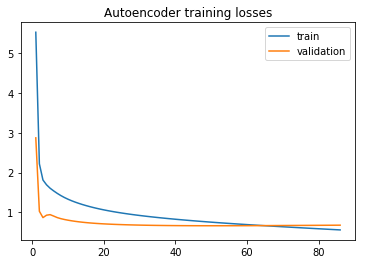

In [8]:
%matplotlib inline
roi.plot_ae_losses()

In [9]:
save_ae_weights_folder = 'O:\\ProgrammingSoftwares\\anaconda_projects\\heart_contour\\roi\\ae_w.pth'
roi.save_ae_weights(save_ae_weights_folder)

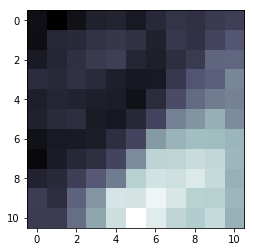

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

idx = 4
_,decoded = roi.autoencoder(ds_valid.__getitem__(idx)['image'])
plt.imshow(np.reshape(decoded.cpu().detach().numpy(), (11,11)), cmap=plt.cm.bone) 

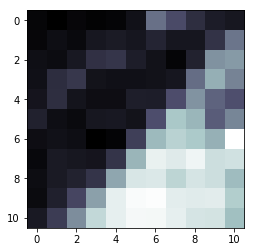

In [11]:
plt.imshow(np.reshape(roi.normalize_range(ds_valid.__getitem__(idx)['image'].cpu()).numpy(), (11,11)), cmap=plt.cm.bone) 

In [99]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision.transforms import Compose
import transform_classes
import torch as th

th.cuda.set_device(0)

csv_file = 'O:/ProgrammingSoftwares/anaconda_projects/heart_contour/sa_all_1/rectangle.csv'
csv_file2 = 'O:/ProgrammingSoftwares/anaconda_projects/heart_contour/sa_all_2/rectangle.csv'
csv_file3 = 'O:/ProgrammingSoftwares/anaconda_projects/heart_contour/sa_all_4/rectangle.csv'
save_model_weights_test = 'O:\\ProgrammingSoftwares\\anaconda_projects\\heart_contour\\roi\\model_test_w.pth'


compose1 = Compose([transform_classes.ReScale64(),transform_classes.StandardScale(),transform_classes.ToTensor()])
compose2 = Compose([transform_classes.ReScale32(),transform_classes.ToTensor()])

ds_train = RoiDataset(csv_file, compose1, compose2,smpl = 256)
ds_valid = RoiDataset(csv_file2, compose1, compose2,smpl = 32)
ds_test = RoiDataset(csv_file3, compose1, compose2,smpl = 32)

loader_train = torch.utils.data.DataLoader(ds_train,batch_size=32, shuffle=True,num_workers=0)
loader_valid = torch.utils.data.DataLoader(ds_valid,batch_size=8, shuffle=False,num_workers=0)
loader_test = torch.utils.data.DataLoader(ds_test, batch_size=8, shuffle=False,num_workers=0)

roi = RoiLearn()
roi.build_model()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(roi.model.parameters())#,weight_decay = 0.0001)
earlystop_info = {'step': 1e-6, 'patience_steps': 30}

ae_weights_folder = 'O:\\ProgrammingSoftwares\\anaconda_projects\\heart_contour\\roi\\ae_w.pth'
roi.load_ae_weights(ae_weights_folder)
roi.ae_weights2model_feature_set()
roi.model.conv1.weight.requires_grad=False
roi.model.conv1.bias.requires_grad=False

In [100]:
import warnings
warnings.filterwarnings('ignore')
torch.cuda.empty_cache()
'''earlystop_info = {'step': 1e-8, 'patience_steps': 10}
roi.model.conv1.weight.requires_grad=True
roi.model.conv1.bias.requires_grad=True'''
roi.learn_roi(loader_train, optimizer, criterion, ep = 1000, dataset_validation = loader_valid, 
              weight_path = save_model_weights_test, dataset_test = loader_test, earlystop_info = earlystop_info,
             plot_filename = 'plot_first.png', plot_test_filename = 'plot_test_first.png')

Test results =>  test_loss:  31.25435336149131  test_dice_loss:  0.04967743041500575
test_center_average_loss:  11.477101045078783 

epoch:  0  train_loss:  66.46243372541217  valid_loss:  35.57130431838976
train_dice_loss:  0.01688246498655673  valid_dice_loss:  0.06341817121038987
train_center_loss:  12.300679071486247  valid_center_loss:  13.430305791766465 

epoch:  5  train_loss:  14.025861826863622  valid_loss:  32.8814364558828
train_dice_loss:  0.005746598061790479  valid_dice_loss:  0.05447890794513227
train_center_loss:  7.38269295522453  valid_center_loss:  13.70391949264215 

epoch:  10  train_loss:  10.61462414932369  valid_loss:  32.19255402041893
train_dice_loss:  0.004508288780740407  valid_dice_loss:  0.05254080680718548
train_center_loss:  6.21495720549939  valid_center_loss:  12.245077471065567 

epoch:  15  train_loss:  9.159511568533375  valid_loss:  31.935854134614797
train_dice_loss:  0.0038939090175983274  valid_dice_loss:  0.052044872162827084
train_center_loss

KeyboardInterrupt: 

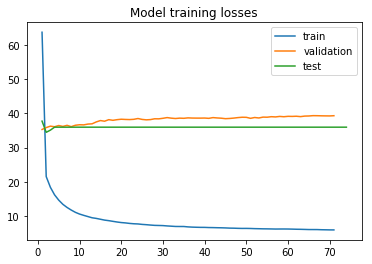

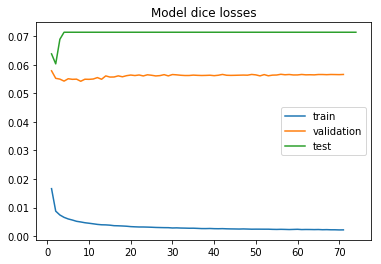

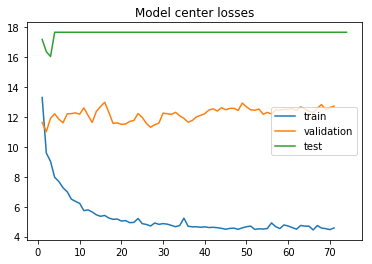

In [58]:
%matplotlib inline
#roi.plot_model_test_losses( 450, 5)
roi.save_model_plots('roi_plot.png')
#roi.save_ae_plots('roi2_plot.png')

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision.transforms import Compose
import transform_classes
import torch as th
th.cuda.set_device(0)

csv_file = 'O:/ProgrammingSoftwares/anaconda_projects/heart_contour/sa_all_2/rectangle.csv'
compose1 = Compose([transform_classes.ReScale64(),transform_classes.StandardScale(),transform_classes.ToTensor()])
compose2 = Compose([transform_classes.ReScale32(),transform_classes.ToTensor()])
ds_valid = RoiDataset(csv_file, compose1, compose2,smpl = 16)
roi = RoiLearn()
roi.load_model_weights('O:\\ProgrammingSoftwares\\anaconda_projects\\heart_contour\\roi\\model_w.pth')

In [18]:
roi.model.conv1.weight.requires_grad=True
roi.model.conv1.bias.requires_grad=True
roi.learn_roi(dataset_loader, optimizer, criterion, ep = 10)
print('Save weights')
save_model_weights_folder = 'O:\\ProgrammingSoftwares\\anaconda_projects\\heart_contour\\roi\\model_w.pth'
roi.save_model_weights(save_model_weights_folder)

epoch:  0  loss:  451.3814063319843
epoch:  1  loss:  451.3813822503478
epoch:  2  loss:  451.3813582795631
epoch:  3  loss:  451.38133441902306
epoch:  4  loss:  451.3813106681244
epoch:  5  loss:  451.38128702626716
epoch:  6  loss:  451.3812634928546
epoch:  7  loss:  451.3812400672935
epoch:  8  loss:  451.3812167489942
epoch:  9  loss:  451.38119353736994
Save weights


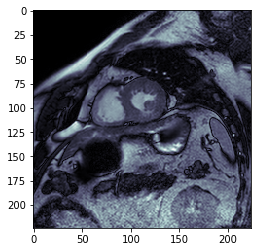

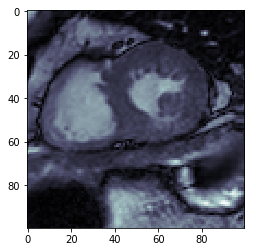

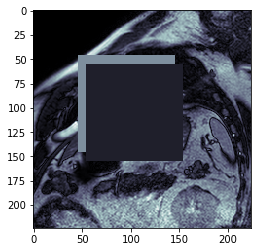

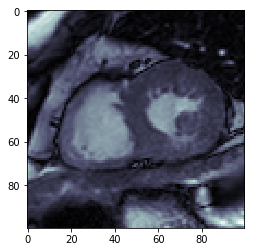

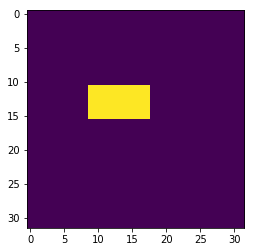

In [95]:
%matplotlib inline
import matplotlib.pyplot as plt
from data_wrangling.con2img import draw_square
from PIL import Image
import cv2
import time

idx = 31
border_size=100
dataset = ds_valid
plt.figure()
cont = dataset.contour_data.iloc[idx]
image = dataset.dcm_images[str(cont['path'])]
plt.imshow(image,cmap=plt.cm.bone)

out = roi.model(torch.from_numpy(np.expand_dims(dataset.__getitem__(idx)['image'], axis = 0)).cuda())
reshaped_output = np.reshape(out.cpu().detach().numpy(), (32,32))
reshaped_output = resize(reshaped_output, (224,224))
max_index = np.unravel_index(np.argmax(reshaped_output), reshaped_output.shape)

plt.figure()
#plt.imshow(reshaped_output,cmap=plt.cm.bone)
#plt.figure()


#img = Image.new('L', (224,224))
#pil_image = Image.fromarray(image).convert("L")
#pil_mask = Image.fromarray(reshaped_output*255).convert("L")
#img.paste(pil_image,mask=pil_mask)

opencv_mask = np.around(reshaped_output)*255
opencv_mask = opencv_mask.astype(np.uint8)

rect = cv2.boundingRect(opencv_mask)
x,y,w,h = rect
center_x = int(x + (w)/2)
center_y = int(y + (h)/2)

x_min = int(center_x - border_size/2)
x_max = int(center_x + border_size/2)
y_min = int(center_y - border_size/2)
y_max = int(center_y + border_size/2)

plt.imshow(image[y_min:y_max,x_min:x_max],cmap=plt.cm.bone)

plt.figure()
image_modify = image.copy()
center = dataset.__getitem__(idx)['mask_center']

image_modify[center['y']-50:center['y']+50,center['x']-50: center['x']+50] = 200



image_modify[y_min:y_max,x_min:x_max] = 50
plt.imshow(image_modify,cmap=plt.cm.bone)
plt.figure()
tt = dataset.contour_data[dataset.contour_data['path'] == str(cont['path'])]
image_modify2 = image.copy()
#image_modify2[int(tt['ymin']):int(tt['ymin']) +100, int(tt['xmin']): int(tt['xmin'])+100] = 50
plt.imshow(image_modify2[center['y']-50:center['y']+50,center['x']-50: center['x']+50],cmap=plt.cm.bone)
plt.figure()
plt.imshow(np.reshape(dataset.__getitem__(idx)['mask'], (32,32)))

[0.12231011]
(14, 15)


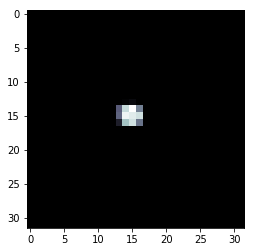

In [18]:
from PIL import Image
import matplotlib.pyplot as plt
#roi.autoencoder()

idx = 6
out = roi.model(torch.from_numpy(np.expand_dims(ds.__getitem__(idx)['image'], axis = 0)).cuda())
#print(np.amax(out.detach().numpy() ))
reshaped_output = np.reshape(out.cpu().detach().numpy(), (32,32))
print(np.amax(out.cpu().detach().numpy(),axis=1))
max_index = np.unravel_index(np.argmax(reshaped_output), reshaped_output.shape)
plt.imshow(np.reshape(out.cpu().detach().numpy(), (32,32)), cmap=plt.cm.bone)

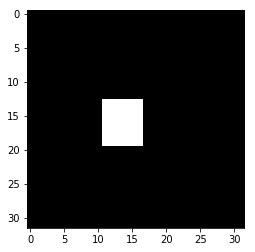

In [5]:
plt.imshow(np.reshape((ds.__getitem__(idx)['mask']).cpu().numpy(), (32,32)), cmap=plt.cm.bone)

In [10]:
torch.cuda.max_memory_allocated()

374413824